In [1]:
# work environment: jl2815
# Standard libraries
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate

import pickle

c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\GEMS_TCO\kernels.py:60: SyntaxWarning: invalid escape sequence '\s'
  '''


In [2]:
lat_lon_resolution = [10,10]
mm_cond_number = 10
params= [60, 5.25, 5.25, 0.2, 0.5, 5]
# params= [20, 8.25, 5.25, 0.2, 0.5, 5]
key_for_dict= 8


# Load the one dictionary to set spaital coordinates
filepath = "C:/Users/joonw/TCO/GEMS_data/data_2023/sparse_cen_map23_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        filepath = f"C:/Users/joonw/TCO/GEMS_data/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)


key_for_dict= 8
analysis_data_map = {}
for i in range(key_for_dict):
    tmp = coarse_dicts[key_idx[i]]
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed'])
    # tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    # Sort by the first two columns
    sorted_indices = np.lexsort((tmp[:, 0], tmp[:, 1]))
    tmp = tmp[sorted_indices]
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range((key_for_dict)):
    tmp = coarse_dicts[key_idx[i]]
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)
          
aggregated_np = aggregated_data.iloc[:,:4].to_numpy()
sorted_indices = np.lexsort((aggregated_np[:, 0], aggregated_np[:, 1]))
aggregated_np = aggregated_np[sorted_indices]
print(f'Aggregated data shape: {aggregated_data.shape}')



instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to scale (0, 1, and 3)
columns_to_scale = [ 3]

aggregated_np2 = aggregated_np.copy()
# Fit and transform the selected columns
aggregated_np2[:, columns_to_scale] = scaler.fit_transform(aggregated_np2[:, columns_to_scale])

Aggregated data shape: (1600, 5)


In [14]:
instance.full_likelihood(params, aggregated_np[:,:4],aggregated_np[:,2], instance.matern_cov_yx)

np.float64(4174.860696545362)

In [16]:
params= [20, 8.25, 5.25, 0.2, 0.5, 5]
# params= [60, 8.25, 5.25, 0.2, 0.5, 5]
out1 = instance.vecchia_like_local(params, instance.matern_cov_yx)
print(out1)

# 2264 2273
# 1928 1729

4336.260475230565


In [18]:
params= [40, 10, 6, 0.2, 0.01, 0.3]
# params= [60, 8.25, 5.25, 0.2, 0.5, 5]
out1 = instance.vecchia_like_local(params, instance.matern_cov_yx)
print(out1)

4335.561906916531


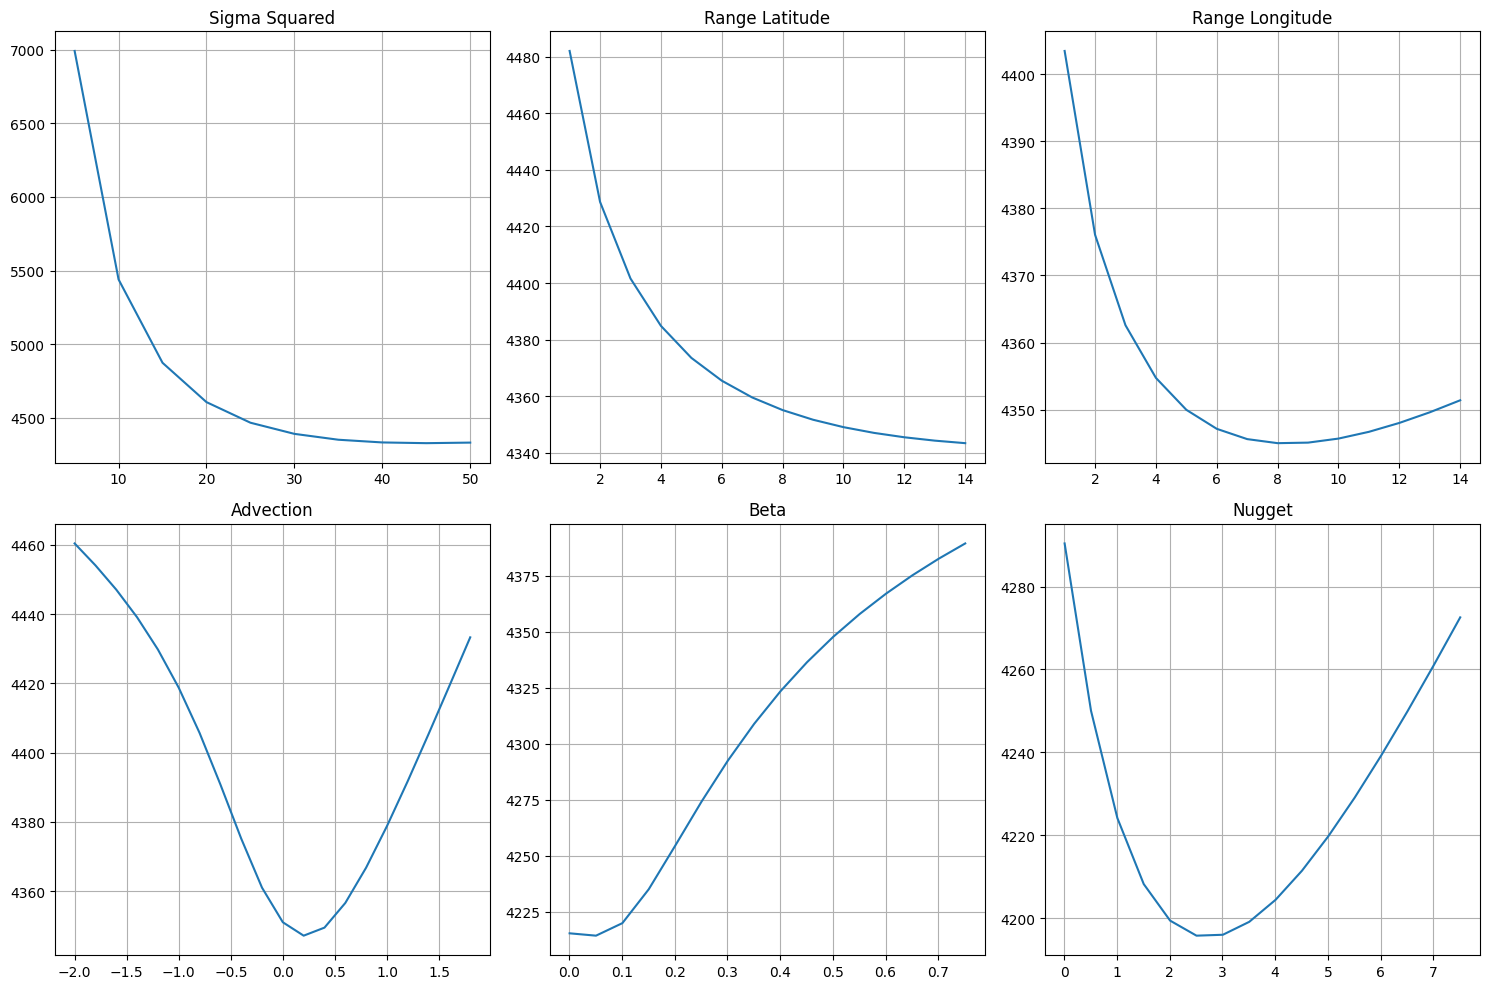

In [19]:
# Data for the plots
simgasq = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
range_lat = np.arange(1, 15, 1)
range_lon = np.arange(1, 15, 1)
advection = np.arange(-2, 2, 0.2)
beta = np.arange(0.001, 0.8, 0.05)
nugget = np.arange(0.01, 8, 0.5)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot each subplot
axs[0, 0].plot(simgasq, [instance.vecchia_like_local([i, 10, 5.25, 0.2, 0.5, 0.5], instance.matern_cov_yx) for i in simgasq])
axs[0, 0].set_title('Sigma Squared')
axs[0, 0].grid(True)

axs[0, 1].plot(range_lat, [instance.vecchia_like_local([40, i, 5.25, 0.2, 0.5, 5], instance.matern_cov_yx) for i in range_lat])
axs[0, 1].set_title('Range Latitude')
axs[0, 1].grid(True)

axs[0, 2].plot(range_lon, [instance.vecchia_like_local([40, 10, i, 0.2, 0.5, 5], instance.matern_cov_yx) for i in range_lon])
axs[0, 2].set_title('Range Longitude')
axs[0, 2].grid(True)

axs[1, 0].plot(advection, [instance.vecchia_like_local([40, 10, 6, i, 0.5, 5], instance.matern_cov_yx) for i in advection])
axs[1, 0].set_title('Advection')
axs[1, 0].grid(True)

axs[1, 1].plot(beta, [instance.vecchia_like_local([40, 10, 6, 0.3, i, 5], instance.matern_cov_yx) for i in beta])
axs[1, 1].set_title('Beta')
axs[1, 1].grid(True)

axs[1, 2].plot(nugget, [instance.vecchia_like_local([40, 10, 6, 0.3, -0.1, i], instance.matern_cov_yx) for i in nugget])
axs[1, 2].set_title('Nugget')
axs[1, 2].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [21]:
instance.lon_key = sorted(np.unique(analysis_data_map['2024_07_y24m07day01_hm01:00'][:,1]), reverse=True)
instance.lon_key = sorted(np.unique(analysis_data_map['2024_07_y24m07day01_hm01:00'][:,1]))
# observation 1: lat key is so much better than lon key
# observation 2: lat key is better with descending order.
number_of_timestamps = instance.number_of_timestamps
instance.cov_map = defaultdict(list)

neg_log_lik = 0
for time_idx in range(number_of_timestamps):
    current_np = instance.input_map[instance.key_list[time_idx]]

    for col_idx in range(len(instance.lon_key)):
       
        current_col = current_np[current_np[:, 1] == instance.lon_key[col_idx]]
        if col_idx <2:
            if time_idx ==0:
                neg_log_lik += instance.full_likelihood(params, current_col, current_col[:,2], instance.matern_cov_yx)
            elif time_idx>0:
                
                onelag_np = instance.input_map[instance.key_list[time_idx-1]]
                cond_col_onelag = onelag_np[(onelag_np[:, 1] == instance.lon_key[col_idx]) ]
                np_arr = np.vstack((current_col, cond_col_onelag))
                
                y_and_neighbors = np_arr[:,2]
                current_y = current_col[:,2]
                locs = np_arr[:,:2]

                p = len(current_col)
                cov_matrix = instance.matern_cov_yx(params=params, y = np_arr, x = np_arr)
                L = np.linalg.cholesky(cov_matrix)
                L11 = L[:p,:p]
                L12 = np.zeros(L[:p,p:].shape)
                L21 = L[p:,:p]
                L22 = L[p:,p:]
                L11_inv = np.linalg.inv(L11)
                L22_inv = np.linalg.inv(L22)

                L_inv = np.block([
                    [L11_inv, L12],
                    [- np.dot( np.dot(L22_inv,L21), L11_inv), L22_inv]
                ])

                tmp1 = np.dot(L_inv,locs)
                tmp2 = np.dot( np.dot(L_inv, locs).T, np.dot(L_inv, y_and_neighbors))
                tmp_for_beta= np.dot(tmp1.T,tmp1)
                beta = np.linalg.solve(tmp_for_beta , tmp2)

                mu = np.dot(locs, beta)
                mu_current = mu[:p]
                mu_neighbors = mu[p:]

                # mean and variance of y|x
                cov_yx = cov_matrix[:p,p:]
                cov_yy= cov_matrix[:p,:p]

                # cov_xx = np.dot(L21,L21.T) +np.dot(L22,L22.T) 
                cov_xx = cov_matrix[p:,p:]
                cov_xx_inv = np.linalg.inv(cov_xx)
            
                cov_ygivenx = cov_yy - np.dot(cov_yx, np.dot(cov_xx_inv, cov_yx.T))

                cond_mean_tmp = np.dot(cov_yx, cov_xx_inv)
                cond_mean = mu_current + np.dot(cond_mean_tmp, (y_and_neighbors[p:]-mu_neighbors) )  # adjust for bias, mean_xz should be 0 which is not true but we can't do same for y1 so just use mean_z almost 0

                alpha = current_y - cond_mean

                quad_form = np.dot(alpha.T, np.linalg.solve(cov_ygivenx,alpha))

                sign, log_det = np.linalg.slogdet(cov_ygivenx)
                # print(log_det)
                neg_log_lik += 0.5 * (1 * np.log(2 * np.pi) + log_det + quad_form)

        elif col_idx>2:  
            
            if time_idx ==0:
                cov_matrix = instance.cov_map[0]['cov_matrix']
                tmp_for_beta = instance.cov_map[0]['tmp_for_beta']
                cov_xx_inv = instance.cov_map[0]['cov_xx_inv']
                L_inv = instance.cov_map[0]['L_inv']
                cov_ygivenx = instance.cov_map[0]['cov_ygivenx'] 
                cond_mean_tmp = instance.cov_map[0]['cond_mean_tmp']
                log_det = instance.cov_map[0]['log_det']
                locs  = instance.cov_map[0]['locs']  
                
                cond_col = current_np[(current_np[:, 1] == instance.lon_key[col_idx-1]) | (current_np[:, 1] == instance.lon_key[col_idx-2])]
                
                np_arr = np.vstack((current_col, cond_col))     
                y_and_neighbors = np_arr[:,2]

            if time_idx >=1:
                cov_matrix = instance.cov_map[1]['cov_matrix']
                tmp_for_beta = instance.cov_map[1]['tmp_for_beta']
                cov_xx_inv = instance.cov_map[1]['cov_xx_inv']
                L_inv = instance.cov_map[1]['L_inv']
                cov_ygivenx = instance.cov_map[1]['cov_ygivenx'] 
                cond_mean_tmp = instance.cov_map[1]['cond_mean_tmp']
                log_det = instance.cov_map[1]['log_det']
                locs  = instance.cov_map[1]['locs']  

                cond_col = current_np[(current_np[:, 1] == instance.lon_key[col_idx-1]) | (current_np[:, 1] == instance.lon_key[col_idx-2])]
                onelag_np = instance.input_map[instance.key_list[time_idx-1]]
                cond_col_onelag = onelag_np[(onelag_np[:, 1] == instance.lon_key[col_idx]) | (onelag_np[:, 1] == instance.lon_key[col_idx-1]) | (onelag_np[:, 1] == instance.lon_key[col_idx-2])]
                cond_col = np.vstack((cond_col, cond_col_onelag))
            
                np_arr = np.vstack((current_col, cond_col))

                y_and_neighbors = np_arr[:,2]
                current_y = current_col[:,2]
                locs = np_arr[:,:2]
                           
            
            current_y = current_col[:,2]   
            p = len(current_col)

            tmp2 = np.dot( np.dot(L_inv, locs).T, np.dot(L_inv, y_and_neighbors))
            beta = np.linalg.solve(tmp_for_beta , tmp2)
            mu = np.dot(locs, beta)
            mu_current = mu[:p]
            mu_neighbors = mu[p:]

            # mean and variance of y|x
            cov_yx = cov_matrix[:p,p:]
            cov_yy= cov_matrix[:p,:p]

            cov_ygivenx = cov_yy - np.dot(cov_yx, np.dot(cov_xx_inv, cov_yx.T))

            cond_mean_tmp = np.dot(cov_yx, cov_xx_inv)
            cond_mean = mu_current + np.dot(cond_mean_tmp, (y_and_neighbors[p:]-mu_neighbors) )  # adjust for bias, mean_xz should be 0 which is not true but we can't do same for y1 so just use mean_z almost 0

            alpha = current_y - cond_mean
            quad_form = np.dot(alpha.T, np.linalg.solve(cov_ygivenx,alpha))
            # print(log_det)
            neg_log_lik += 0.5 * (1 * np.log(2 * np.pi) + log_det + quad_form)

        else:
            if time_idx > 1:
                cov_matrix = instance.cov_map[1]['cov_matrix']
                tmp_for_beta = instance.cov_map[1]['tmp_for_beta']
                cov_xx_inv = instance.cov_map[1]['cov_xx_inv']
                L_inv = instance.cov_map[1]['L_inv']
                cov_ygivenx = instance.cov_map[1]['cov_ygivenx'] 
                cond_mean_tmp = instance.cov_map[1]['cond_mean_tmp']
                log_det = instance.cov_map[1]['log_det']
                locs  = instance.cov_map[1]['locs']
         
        
                cond_col = current_np[(current_np[:, 1] == instance.lon_key[col_idx-1]) | (current_np[:, 1] == instance.lon_key[col_idx-2])]
                onelag_np = instance.input_map[instance.key_list[time_idx-1]]
                cond_col_onelag = onelag_np[(onelag_np[:, 1] == instance.lon_key[col_idx]) | (onelag_np[:, 1] == instance.lon_key[col_idx-1]) | (onelag_np[:, 1] == instance.lon_key[col_idx-2])]
                cond_col = np.vstack((cond_col, cond_col_onelag))
                
                np_arr = np.vstack((current_col, cond_col)) 
                y_and_neighbors = np_arr[:,2]
                current_y = current_col[:,2]  

                p = len(current_col)
                # print(f' {L_inv.shape}, {locs.shape}, {y_and_neighbors.shape}')
                
                tmp2 = np.dot( np.dot(L_inv, locs).T, np.dot(L_inv, y_and_neighbors))
                beta = np.linalg.solve(tmp_for_beta , tmp2)
                mu = np.dot(locs, beta)
                mu_current = mu[:p]
                mu_neighbors = mu[p:]

                # mean and variance of y|x
                cov_yx = cov_matrix[:p,p:]
                cov_yy= cov_matrix[:p,:p]

                cov_ygivenx = cov_yy - np.dot(cov_yx, np.dot(cov_xx_inv, cov_yx.T))

                cond_mean_tmp = np.dot(cov_yx, cov_xx_inv)
                cond_mean = mu_current + np.dot(cond_mean_tmp, (y_and_neighbors[p:]-mu_neighbors) )  # adjust for bias, mean_xz should be 0 which is not true but we can't do same for y1 so just use mean_z almost 0

                alpha = current_y - cond_mean

                quad_form = np.dot(alpha.T, np.linalg.solve(cov_ygivenx,alpha))
                # print(log_det)
                neg_log_lik += 0.5 * (1 * np.log(2 * np.pi) + log_det + quad_form)
                continue

            elif time_idx == 0:
                cond_col = current_np[(current_np[:, 1] == instance.lon_key[col_idx-1]) | (current_np[:, 1] == instance.lon_key[col_idx-2])]
            else:    

                cond_col = current_np[(current_np[:, 1] == instance.lon_key[col_idx-1]) | (current_np[:, 1] == instance.lon_key[col_idx-2])]
                onelag_np = instance.input_map[instance.key_list[time_idx-1]]
                cond_col_onelag = onelag_np[(onelag_np[:, 1] == instance.lon_key[col_idx]) | (onelag_np[:, 1] == instance.lon_key[col_idx-1]) | (onelag_np[:, 1] == instance.lon_key[col_idx-2])]
                cond_col = np.vstack((cond_col, cond_col_onelag))
            
            np_arr = np.vstack((current_col, cond_col))

            y_and_neighbors = np_arr[:,2]
            current_y = current_col[:,2]
            locs = np_arr[:,:2]

            p = len(current_col)
            cov_matrix = instance.matern_cov_yx(params=params, y = np_arr, x = np_arr)
            L = np.linalg.cholesky(cov_matrix)
            L11 = L[:p,:p]
            L12 = np.zeros(L[:p,p:].shape)
            L21 = L[p:,:p]
            L22 = L[p:,p:]
            L11_inv = np.linalg.inv(L11)
            L22_inv = np.linalg.inv(L22)

            L_inv = np.block([
                [L11_inv, L12],
                [- np.dot( np.dot(L22_inv,L21), L11_inv), L22_inv]
            ])

            tmp1 = np.dot(L_inv,locs)
            tmp2 = np.dot( np.dot(L_inv, locs).T, np.dot(L_inv, y_and_neighbors))
            tmp_for_beta= np.dot(tmp1.T,tmp1)
            beta = np.linalg.solve(tmp_for_beta , tmp2)

            mu = np.dot(locs, beta)
            mu_current = mu[:p]
            mu_neighbors = mu[p:]

            # mean and variance of y|x
            cov_yx = cov_matrix[:p,p:]
            cov_yy= cov_matrix[:p,:p]

            # cov_xx = np.dot(L21,L21.T) +np.dot(L22,L22.T) 
            cov_xx = cov_matrix[p:,p:]
            cov_xx_inv = np.linalg.inv(cov_xx)
        
            cov_ygivenx = cov_yy - np.dot(cov_yx, np.dot(cov_xx_inv, cov_yx.T))

            cond_mean_tmp = np.dot(cov_yx, cov_xx_inv)
            cond_mean = mu_current + np.dot(cond_mean_tmp, (y_and_neighbors[p:]-mu_neighbors) )  # adjust for bias, mean_xz should be 0 which is not true but we can't do same for y1 so just use mean_z almost 0

            alpha = current_y - cond_mean

            quad_form = np.dot(alpha.T, np.linalg.solve(cov_ygivenx,alpha))

            sign, log_det = np.linalg.slogdet(cov_ygivenx)
            # print(log_det)
            neg_log_lik += 0.5 * (1 * np.log(2 * np.pi) + log_det + quad_form)

            if time_idx == 0:
                instance.cov_map[0] = {
                    'tmp_for_beta': tmp_for_beta,
                    'cov_xx_inv': cov_xx_inv,
                    'cov_matrix': cov_matrix,
                    'L_inv':L_inv,
                    'cov_ygivenx':cov_ygivenx,
                    'cond_mean_tmp': cond_mean_tmp,
                    'log_det': log_det,
                    'locs':locs
                }   
            elif time_idx ==1:   
                instance.cov_map[1] = {
                    'tmp_for_beta': tmp_for_beta,
                    'cov_xx_inv': cov_xx_inv,
                    'cov_matrix': cov_matrix,
                    'L_inv':L_inv,
                    'cov_ygivenx':cov_ygivenx,
                    'cond_mean_tmp': cond_mean_tmp,
                    'log_det': log_det,
                    'locs':locs
                }

            
neg_log_lik        

np.float64(3254.1235852454247)

Latitude slice.

It performs worse than longitude slice. 

In [22]:
instance.lat_key = sorted(np.unique(analysis_data_map['2024_07_y24m07day01_hm01:00'][:,0]))
# instance.lat_key = sorted(np.unique(analysis_data_map['2024_07_y24m07day01_hm01:00'][:,1]))
# observation 1: lat key is so much better than lon key
# observation 2: lat key is better with descending order.
number_of_timestamps = instance.number_of_timestamps
instance.cov_map = defaultdict(list)


neg_log_lik = 0
for time_idx in range(number_of_timestamps):
    current_np = instance.input_map[instance.key_list[time_idx]]

    for col_idx in range(len(instance.lat_key)):
        current_col = current_np[current_np[:, 0] == instance.lat_key[col_idx]]

        if col_idx <2:
            neg_log_lik += instance.full_likelihood(params, current_col, current_col[:,2], instance.matern_cov_yx)

        elif col_idx>2:  
            if time_idx ==0:

                cov_matrix = instance.cov_map[0]['cov_matrix']
                tmp_for_beta = instance.cov_map[0]['tmp_for_beta']
                cov_xx_inv = instance.cov_map[0]['cov_xx_inv']
                L_inv = instance.cov_map[0]['L_inv']
                cov_ygivenx = instance.cov_map[0]['cov_ygivenx'] 
                cond_mean_tmp = instance.cov_map[0]['cond_mean_tmp']
                log_det = instance.cov_map[0]['log_det']
                locs  = instance.cov_map[0]['locs']  
                
                cond_col = current_np[(current_np[:, 0] == instance.lat_key[col_idx-1]) | (current_np[:, 0] == instance.lat_key[col_idx-2])]
                
                np_arr = np.vstack((current_col, cond_col))     
                y_and_neighbors = np_arr[:,2]



            if time_idx >=1:
                cov_matrix = instance.cov_map[1]['cov_matrix']
                tmp_for_beta = instance.cov_map[1]['tmp_for_beta']
                cov_xx_inv = instance.cov_map[1]['cov_xx_inv']
                L_inv = instance.cov_map[1]['L_inv']
                cov_ygivenx = instance.cov_map[1]['cov_ygivenx'] 
                cond_mean_tmp = instance.cov_map[1]['cond_mean_tmp']
                log_det = instance.cov_map[1]['log_det']
                locs  = instance.cov_map[1]['locs']  

                cond_col = current_np[(current_np[:, 0] == instance.lat_key[col_idx-1]) | (current_np[:, 0] == instance.lat_key[col_idx-2])]
                onelag_np = instance.input_map[instance.key_list[time_idx-1]]
                cond_col_onelag = onelag_np[(onelag_np[:, 0] == instance.lat_key[col_idx]) | (onelag_np[:, 0] == instance.lat_key[col_idx-1]) | (onelag_np[:, 0] == instance.lat_key[col_idx-2])]
                cond_col = np.vstack((cond_col, cond_col_onelag))
            
                np_arr = np.vstack((current_col, cond_col))

                y_and_neighbors = np_arr[:,2]
                current_y = current_col[:,2]
                locs = np_arr[:,:2]
                           
            
            current_y = current_col[:,2]   
            p = len(current_col)

            tmp2 = np.dot( np.dot(L_inv, locs).T, np.dot(L_inv, y_and_neighbors))
            beta = np.linalg.solve(tmp_for_beta , tmp2)
            mu = np.dot(locs, beta)
            mu_current = mu[:p]
            mu_neighbors = mu[p:]

            # mean and variance of y|x
            cov_yx = cov_matrix[:p,p:]
            cov_yy= cov_matrix[:p,:p]

            cov_ygivenx = cov_yy - np.dot(cov_yx, np.dot(cov_xx_inv, cov_yx.T))

            cond_mean_tmp = np.dot(cov_yx, cov_xx_inv)
            cond_mean = mu_current + np.dot(cond_mean_tmp, (y_and_neighbors[p:]-mu_neighbors) )  # adjust for bias, mean_xz should be 0 which is not true but we can't do same for y1 so just use mean_z almost 0

            alpha = current_y - cond_mean

            quad_form = np.dot(alpha.T, np.linalg.solve(cov_ygivenx,alpha))
            # print(log_det)
            neg_log_lik += 0.5 * (1 * np.log(2 * np.pi) + log_det + quad_form)

        else:
            if time_idx > 1:
                cov_matrix = instance.cov_map[1]['cov_matrix']
                tmp_for_beta = instance.cov_map[1]['tmp_for_beta']
                cov_xx_inv = instance.cov_map[1]['cov_xx_inv']
                L_inv = instance.cov_map[1]['L_inv']
                cov_ygivenx = instance.cov_map[1]['cov_ygivenx'] 
                cond_mean_tmp = instance.cov_map[1]['cond_mean_tmp']
                log_det = instance.cov_map[1]['log_det']
                locs  = instance.cov_map[1]['locs']
         
        
                cond_col = current_np[(current_np[:, 0] == instance.lat_key[col_idx-1]) | (current_np[:, 0] == instance.lat_key[col_idx-2])]
                onelag_np = instance.input_map[instance.key_list[time_idx-1]]
                cond_col_onelag = onelag_np[(onelag_np[:, 0] == instance.lat_key[col_idx]) | (onelag_np[:, 0] == instance.lat_key[col_idx-1]) | (onelag_np[:, 0] == instance.lat_key[col_idx-2])]
                cond_col = np.vstack((cond_col, cond_col_onelag))
                np_arr = np.vstack((current_col, cond_col)) 
                y_and_neighbors = np_arr[:,2]
                current_y = current_col[:,2]  

                p = len(current_col)
                # print(f' {L_inv.shape}, {locs.shape}, {y_and_neighbors.shape}')
                
                tmp2 = np.dot( np.dot(L_inv, locs).T, np.dot(L_inv, y_and_neighbors))
                beta = np.linalg.solve(tmp_for_beta , tmp2)
                mu = np.dot(locs, beta)
                mu_current = mu[:p]
                mu_neighbors = mu[p:]

                # mean and variance of y|x
                cov_yx = cov_matrix[:p,p:]
                cov_yy= cov_matrix[:p,:p]

                cov_ygivenx = cov_yy - np.dot(cov_yx, np.dot(cov_xx_inv, cov_yx.T))

                cond_mean_tmp = np.dot(cov_yx, cov_xx_inv)
                cond_mean = mu_current + np.dot(cond_mean_tmp, (y_and_neighbors[p:]-mu_neighbors) )  # adjust for bias, mean_xz should be 0 which is not true but we can't do same for y1 so just use mean_z almost 0

                alpha = current_y - cond_mean

                quad_form = np.dot(alpha.T, np.linalg.solve(cov_ygivenx,alpha))
                # print(log_det)
                neg_log_lik += 0.5 * (1 * np.log(2 * np.pi) + log_det + quad_form)

            elif time_idx == 0:
                
                cond_col = current_np[(current_np[:, 0] == instance.lat_key[col_idx-1]) | (current_np[:, 0] == instance.lat_key[col_idx-2])]
                
            else:    


                cond_col = current_np[(current_np[:, 0] == instance.lat_key[col_idx-1]) | (current_np[:, 0] == instance.lat_key[col_idx-2])]
          
                onelag_np = instance.input_map[instance.key_list[time_idx-1]]
                cond_col_onelag = onelag_np[(onelag_np[:, 0] == instance.lat_key[col_idx]) | (onelag_np[:, 0] == instance.lat_key[col_idx-1]) | (onelag_np[:, 0] == instance.lat_key[col_idx-2])]
                cond_col = np.vstack((cond_col, cond_col_onelag))
            
            np_arr = np.vstack((current_col, cond_col))

            y_and_neighbors = np_arr[:,2]
            current_y = current_col[:,2]
            locs = np_arr[:,:2]

            p = len(current_col)
            cov_matrix = instance.matern_cov_yx(params=params, y = np_arr, x = np_arr)
            L = np.linalg.cholesky(cov_matrix)
            L11 = L[:p,:p]
            L12 = np.zeros(L[:p,p:].shape)
            L21 = L[p:,:p]
            L22 = L[p:,p:]
            L11_inv = np.linalg.inv(L11)
            L22_inv = np.linalg.inv(L22)

            L_inv = np.block([
                [L11_inv, L12],
                [- np.dot( np.dot(L22_inv,L21), L11_inv), L22_inv]
            ])

            tmp1 = np.dot(L_inv,locs)
            tmp2 = np.dot( np.dot(L_inv, locs).T, np.dot(L_inv, y_and_neighbors))
            tmp_for_beta= np.dot(tmp1.T,tmp1)
            beta = np.linalg.solve(tmp_for_beta , tmp2)

            mu = np.dot(locs, beta)
            mu_current = mu[:p]
            mu_neighbors = mu[p:]

            # mean and variance of y|x
            cov_yx = cov_matrix[:p,p:]
            cov_yy= cov_matrix[:p,:p]

            # cov_xx = np.dot(L21,L21.T) +np.dot(L22,L22.T) 
            cov_xx = cov_matrix[p:,p:]
            cov_xx_inv = np.linalg.inv(cov_xx)
        
            cov_ygivenx = cov_yy - np.dot(cov_yx, np.dot(cov_xx_inv, cov_yx.T))

            cond_mean_tmp = np.dot(cov_yx, cov_xx_inv)
            cond_mean = mu_current + np.dot(cond_mean_tmp, (y_and_neighbors[p:]-mu_neighbors) )  # adjust for bias, mean_xz should be 0 which is not true but we can't do same for y1 so just use mean_z almost 0

            alpha = current_y - cond_mean

            quad_form = np.dot(alpha.T, np.linalg.solve(cov_ygivenx,alpha))

            sign, log_det = np.linalg.slogdet(cov_ygivenx)
            # print(log_det)
            neg_log_lik += 0.5 * (1 * np.log(2 * np.pi) + log_det + quad_form)

            if time_idx == 0:
                instance.cov_map[0] = {
                    'tmp_for_beta': tmp_for_beta,
                    'cov_xx_inv': cov_xx_inv,
                    'cov_matrix': cov_matrix,
                    'L_inv':L_inv,
                    'cov_ygivenx':cov_ygivenx,
                    'cond_mean_tmp': cond_mean_tmp,
                    'log_det': log_det,
                    'locs':locs
                }   
            elif time_idx ==1:   
                instance.cov_map[1] = {
                    'tmp_for_beta': tmp_for_beta,
                    'cov_xx_inv': cov_xx_inv,
                    'cov_matrix': cov_matrix,
                    'L_inv':L_inv,
                    'cov_ygivenx':cov_ygivenx,
                    'cond_mean_tmp': cond_mean_tmp,
                    'log_det': log_det,
                    'locs':locs
                }

            
neg_log_lik        

np.float64(24292.051949258355)